# **CS 6120: Natural Language Processing - Prof. Ahmad Uzair** 

### **Assignment 3: n-gram Language Models, Word Sense disambiguation(LSA using SVD), LSTM**

### **Total points: 100**


# Q1. Latent Semantic Analysis (35 Points) 


 - A. Singular Value Decomposition (SVD) based distributed representation of text and documents. You can use python libraries for matrix decomposition (scipy). To demonstrate your work, use the example dataset (Table 2) of "R. A. Harshman (1990). Indexing by latent semantic analysis. Journal of the American society for information science". (10 Points)

 - B. Visualize (2-D) the documents and terms using library of your choice. (10 Points)

 - C. Implement a function that converts a query string to distributed representation and retrieves relevent documents. Visualize the the results as shown in Fig 1 of the paper. (10 Points)

## <CENTER>Task-1 (10 Points)

In [1]:
import numpy as np
import sklearn
import string
from pprint import pprint
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import TruncatedSVD
from scipy.sparse.linalg import svds
from sklearn.utils.extmath import randomized_svd
from sklearn import preprocessing
import pandas as pd
import re
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import  word_tokenize 
import nltk
from sklearn import metrics
from matplotlib import pyplot as plt

In [3]:
import nltk
nltk.download('words')

from nltk.corpus import words
import re

[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Unzipping corpora/words.zip.


### Input data

In [6]:
#Dataset
c1 = 'Human machine interface for Lab ABC computer applications'
c2 = 'A survey of user opinion of computer system response time'
c3 = 'The EPS user interface management system'
c4 = 'System and human system engineering testing of EPS'
c5 = 'Relation of user-perceived response time to error measurement'
m1 = 'The generation of random, binary, unordered trees'
m2 = 'The intersection graph of paths in trees'
m3 = 'Graph minors IV: Widths of trees and well-quasi-ordering'
m4 = 'Graph minors: A survey'
documents = [c1, c2, c3, c4, c5, m1, m2, m3, m4]

### Perform preprocessing of documents

In the below cell remove punctuations and keep only words which belong to nltk corpus

In [4]:
# TASK CELL

def preprocess(message):
    '''
    Input:
        message: a string containing a message.
    Output:
        preprocessed_message_list: a list of words containing the processed message. 

    '''
    message = message.replace('-', ' ')
    
    # Remove punctuations from text
    message = re.sub(r'[^\w\s]','',message)
    
    # Lowercase excluding ALL CAPS words and words not in nltk corpora
    preprocessed_message_list = []
    for w in message.split(' '):
        if (w.isupper() and len(w)!=1)  or (w.lower() not in words.words()) :
            preprocessed_message_list.append(w)
        else:
            preprocessed_message_list.append(w.lower())

    return preprocessed_message_list

### Verify preprocessed data

In [7]:
for sent in documents:
    print(preprocess(sent))

['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']


##### Expected Output
```CPP
['human', 'machine', 'interface', 'for', 'lab', 'ABC', 'computer', 'applications']
['a', 'survey', 'of', 'user', 'opinion', 'of', 'computer', 'system', 'response', 'time']
['the', 'EPS', 'user', 'interface', 'management', 'system']
['system', 'and', 'human', 'system', 'engineering', 'testing', 'of', 'EPS']
['relation', 'of', 'user', 'perceived', 'response', 'time', 'to', 'error', 'measurement']
['the', 'generation', 'of', 'random', 'binary', 'unordered', 'trees']
['the', 'intersection', 'graph', 'of', 'paths', 'in', 'trees']
['graph', 'minors', 'IV', 'Widths', 'of', 'trees', 'and', 'well', 'quasi', 'ordering']
['graph', 'minors', 'a', 'survey']
```

### Assign names to document names
In the below cell create a list of document names. It will be later used to visualize documents

In [8]:
def createDocName(documents):
    '''
    Input:
        documents: list of documents.
    Output:
        doc_names: a list of document names. 

    '''
    doc_names = ['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
    
    return doc_names

In [9]:
docName = createDocName(documents)
print(docName)

['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']


##### Expected Output
``` CPP
['c1', 'c2', 'c3', 'c4', 'c5', 'm1', 'm2', 'm3', 'm4']
```

### Words to Index mapping
Retrieve words from documents and create map of word and associate index to it

In [16]:
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stopwords = stopwords.words('english')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [18]:
def build_word_to_ix(documents, stopwords=None):
    '''
    Input:
        documents: list of documents
        stopwords: list of stopwords
    Output:
        doc_names: map of words and assoicated index. 

    '''
    # Update the count of that particular word
    word_count = {}
    for d in documents:
        for w in preprocess(d):
            if w in word_count.keys():
                word_count[w] += 1
            else:
                word_count[w] = 1
    
    # Assign index to the word map
    word_to_ix = {}
    counter = 0
    filtered_word = []
    for k in word_count:
        if word_count[k] > 1 and k not in stopwords:
            word_to_ix[k] = counter
            counter += 1
    
    return word_to_ix


In [19]:
word_to_ix = build_word_to_ix(documents, stopwords)
print(word_to_ix)

{'human': 0, 'interface': 1, 'computer': 2, 'survey': 3, 'user': 4, 'system': 5, 'response': 6, 'time': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}


##### Expected Output
```CPP
{'human': 0, 'interface': 1, 'computer': 2, 'user': 3, 'survey': 4, 'system': 5, 'time': 6, 'response': 7, 'EPS': 8, 'trees': 9, 'graph': 10, 'minors': 11}
```

### Document-Terms count matrix

In [20]:
def build_td_matrix(documents, word_to_ix):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
    Output:
        td_matrix: matrix of count of words in documents, each row 
            represent a word and each column represent a document

    '''
    td_matrix = np.zeros((len(word_to_ix), len(documents)))
    
    # Preprocess each document
    preprocessed_documents = []
    for doc in documents:
        preprocessed_documents.append(preprocess(doc))
    
    # Assign values to td_matrix
    for word in word_to_ix:
        for j in range(0,len(preprocessed_documents)):
            count = preprocessed_documents[j].count(word)
            td_matrix[word_to_ix[word]][j] = count
    return td_matrix

In [21]:
X = build_td_matrix(documents, word_to_ix)
print(X)

[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]


##### Expected Output
```CPP
[[1. 0. 0. 1. 0. 0. 0. 0. 0.]
 [1. 0. 1. 0. 0. 0. 0. 0. 0.]
 [1. 1. 0. 0. 0. 0. 0. 0. 0.]
 [0. 1. 1. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 0. 0. 0. 0. 1.]
 [0. 1. 1. 2. 0. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 1. 0. 0. 1. 0. 0. 0. 0.]
 [0. 0. 1. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 1. 1. 1. 0.]
 [0. 0. 0. 0. 0. 0. 1. 1. 1.]
 [0. 0. 0. 0. 0. 0. 0. 1. 1.]]
 ```

### Singular Value Decomposition
Perform singular value decomposition of count matrix into term singular vector matrix, singular value matrix and document singular vector matrix
- To perform the singular value decompostion please check tutorial:
https://numpy.org/doc/stable/reference/generated/numpy.linalg.svd.html

In [23]:
#from numpy.linalg import svd
from sklearn.decomposition import TruncatedSVD
def svd(documents, word_to_ix, rank):
    '''
    Input:
        documents: list of documents.
        word_to_ix: {word, index} map
        rank: number of colums/rows to retain in decomposed matrix
    Output:
        Uk: term singular vector matrix
        Sk: singular value matrix
        Vk_t: transpose of document singular vector matrix
    '''
    A = build_td_matrix(documents, word_to_ix)
    
    U, S, V = np.linalg.svd(A)
    
    # Only retain a specific number of colums/rows according to rank
    Uk = U[:,:rank]
    Sk = np.diag(S)[:rank,:rank]
    Vk_t = V[:rank,].transpose()
    return Uk, Sk, Vk_t

In [24]:
Uk, Sk, Vk_t = svd(documents, word_to_ix, 2)
print(Uk)
print(Sk)
print(Vk_t)

[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.20591786  0.27364743]
 [-0.40359886  0.05707026]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]


##### Expected Output
```CPP 
[[-0.22135078 -0.11317962]
 [-0.1976454  -0.07208778]
 [-0.24047023  0.04315195]
 [-0.40359886  0.05707026]
 [-0.20591786  0.27364743]
 [-0.64448115 -0.16730121]
 [-0.26503747  0.10715957]
 [-0.26503747  0.10715957]
 [-0.30082816 -0.14127047]
 [-0.01274618  0.49016179]
 [-0.03613585  0.62278523]
 [-0.03175633  0.45050892]]
[[3.34088375 0.        ]
 [0.         2.541701  ]]
[[-0.1973928  -0.05591352]
 [-0.60599027  0.16559288]
 [-0.46291751 -0.12731206]
 [-0.54211442 -0.23175523]
 [-0.27946911  0.10677472]
 [-0.00381521  0.19284794]
 [-0.01463147  0.43787488]
 [-0.02413684  0.6151219 ]
 [-0.08195737  0.52993707]]
 ```

## <CENTER>Task-2 (10 Points)

### Visualize documents in 2D space

In [25]:
#Visualize documents and print coordinates
# Compute the Dot Product 
documents_array = np.dot(Vk_t,Sk)

documents_array

array([[-0.65946641, -0.14211544],
       [-2.02454304,  0.42088758],
       [-1.54655358, -0.32358919],
       [-1.81114125, -0.5890525 ],
       [-0.9336738 ,  0.2713894 ],
       [-0.01274618,  0.49016179],
       [-0.04888203,  1.11294703],
       [-0.08063836,  1.56345595],
       [-0.27381004,  1.34694158]])

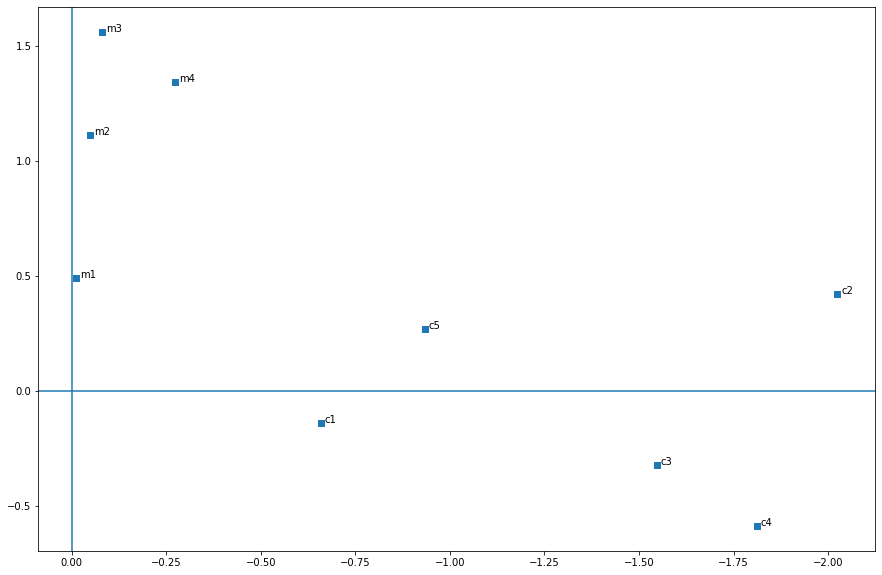

In [26]:
import numpy as np
from matplotlib import pyplot as plt

# Set figure size
plt.figure(figsize=(15,10))

# Scatter plot
x = documents_array[:,0]
y = documents_array[:,1]
plt.scatter(x, y, marker='s')

# Annotate
for i, j in enumerate(docName):
    plt.annotate(j, (x[i]-0.01, y[i]))
    
# Invert the axis
plt.gca().invert_xaxis()

# Axis lines
plt.axhline(0)
plt.axvline(0)

# Display the plot
plt.show()

##### Expected
```CPP
[[-0.65946641 -0.14211544]
 [-2.02454304  0.42088758]
 [-1.54655358 -0.32358919]
 [-1.81114125 -0.5890525 ]
 [-0.9336738   0.2713894 ]
 [-0.01274618  0.49016179]
 [-0.04888203  1.11294703]
 [-0.08063836  1.56345595]
 [-0.27381004  1.34694158]]
```
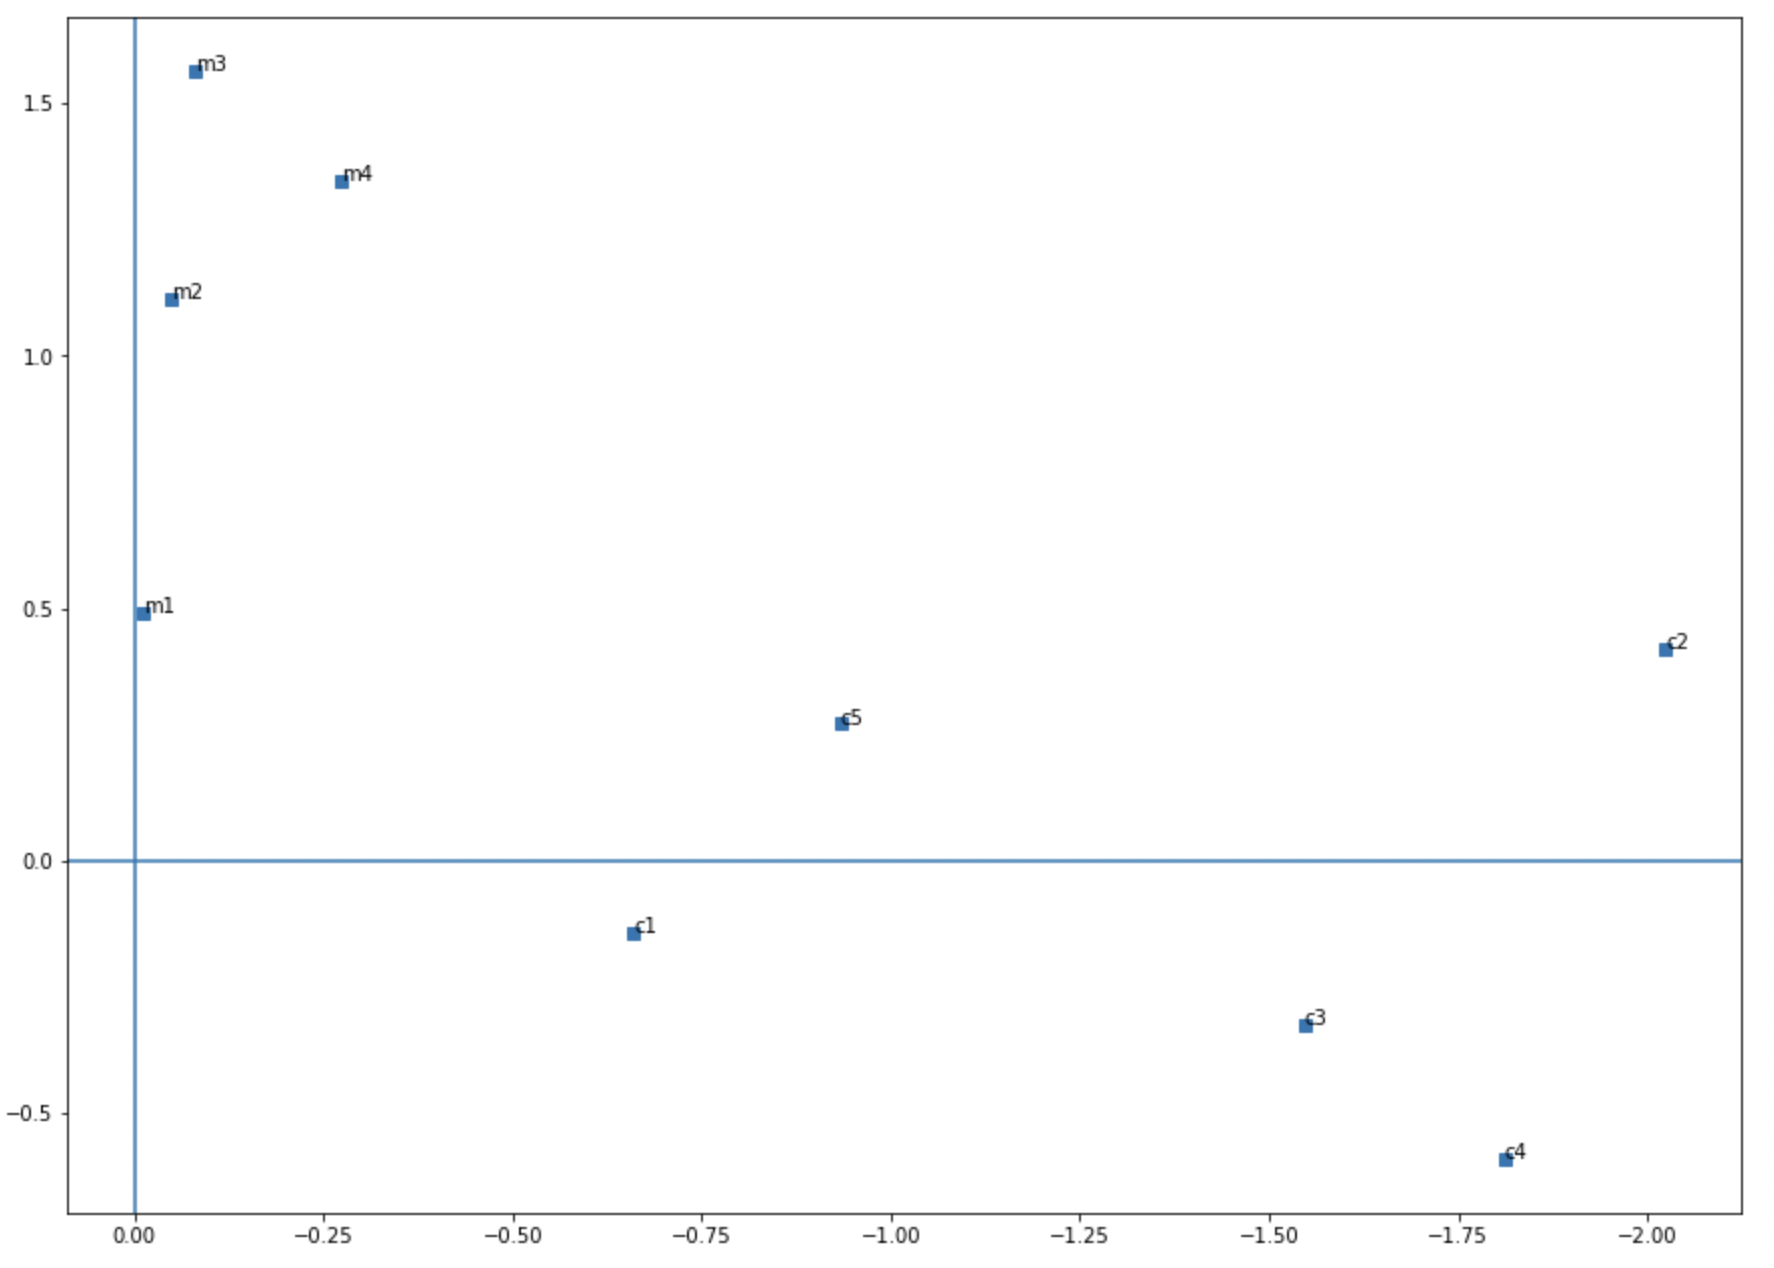

### Visualize terms in 2D space

In [27]:
#Visualize terms and print coordinates
# Compute the Dot Product 
terms_array = np.dot(Uk,Sk)

terms_array

array([[-0.73950722, -0.28766875],
       [-0.66031031, -0.18322558],
       [-0.80338307,  0.10967936],
       [-0.68794764,  0.69552995],
       [-1.34837689,  0.14505553],
       [-2.15313661, -0.42522964],
       [-0.88545938,  0.27236759],
       [-0.88545938,  0.27236759],
       [-1.00503193, -0.35906729],
       [-0.04258352,  1.24584472],
       [-0.12072567,  1.58293385],
       [-0.1060942 ,  1.14505897]])

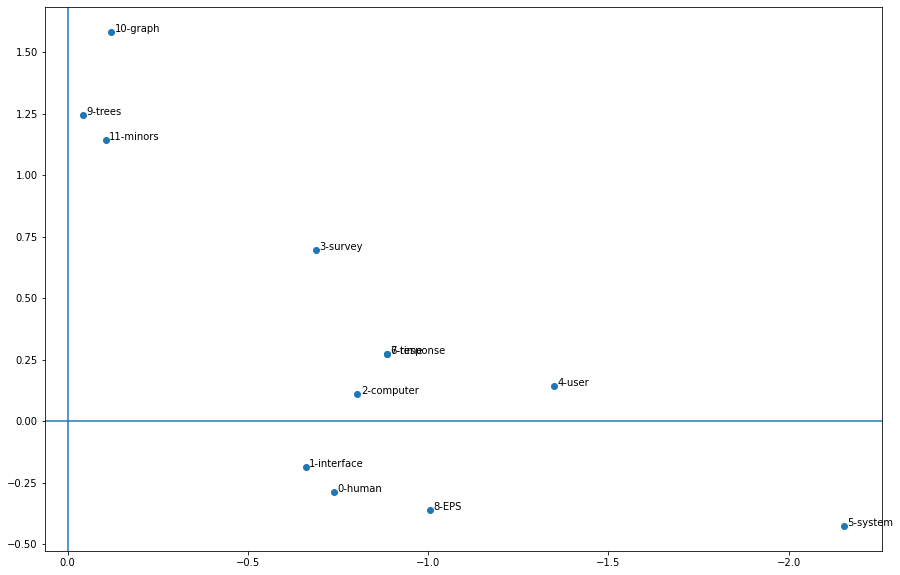

In [28]:
import numpy as np
from matplotlib import pyplot as plt

# Set figure size
plt.figure(figsize=(15,10))

# Scatter plot
x = terms_array[:,0]
y = terms_array[:,1]
plt.scatter(x, y)

# Annotate
for i, j in enumerate(word_to_ix):
    plt.annotate(str(i)+ "-" + j, (x[i]-0.01, y[i]))
    
# Invert the axis
plt.gca().invert_xaxis()

# Axis lines
plt.axhline(0)
plt.axvline(0)

# Display the plot
plt.show()

##### Expected
```CPP
[[-0.73950722 -0.28766875]
 [-0.66031031 -0.18322558]
 [-0.80338307  0.10967936]
 [-1.34837689  0.14505553]
 [-0.68794764  0.69552995]
 [-2.15313661 -0.42522964]
 [-0.88545938  0.27236759]
 [-0.88545938  0.27236759]
 [-1.00503193 -0.35906729]
 [-0.04258352  1.24584472]
 [-0.12072567  1.58293385]
 [-0.1060942   1.14505897]]
```
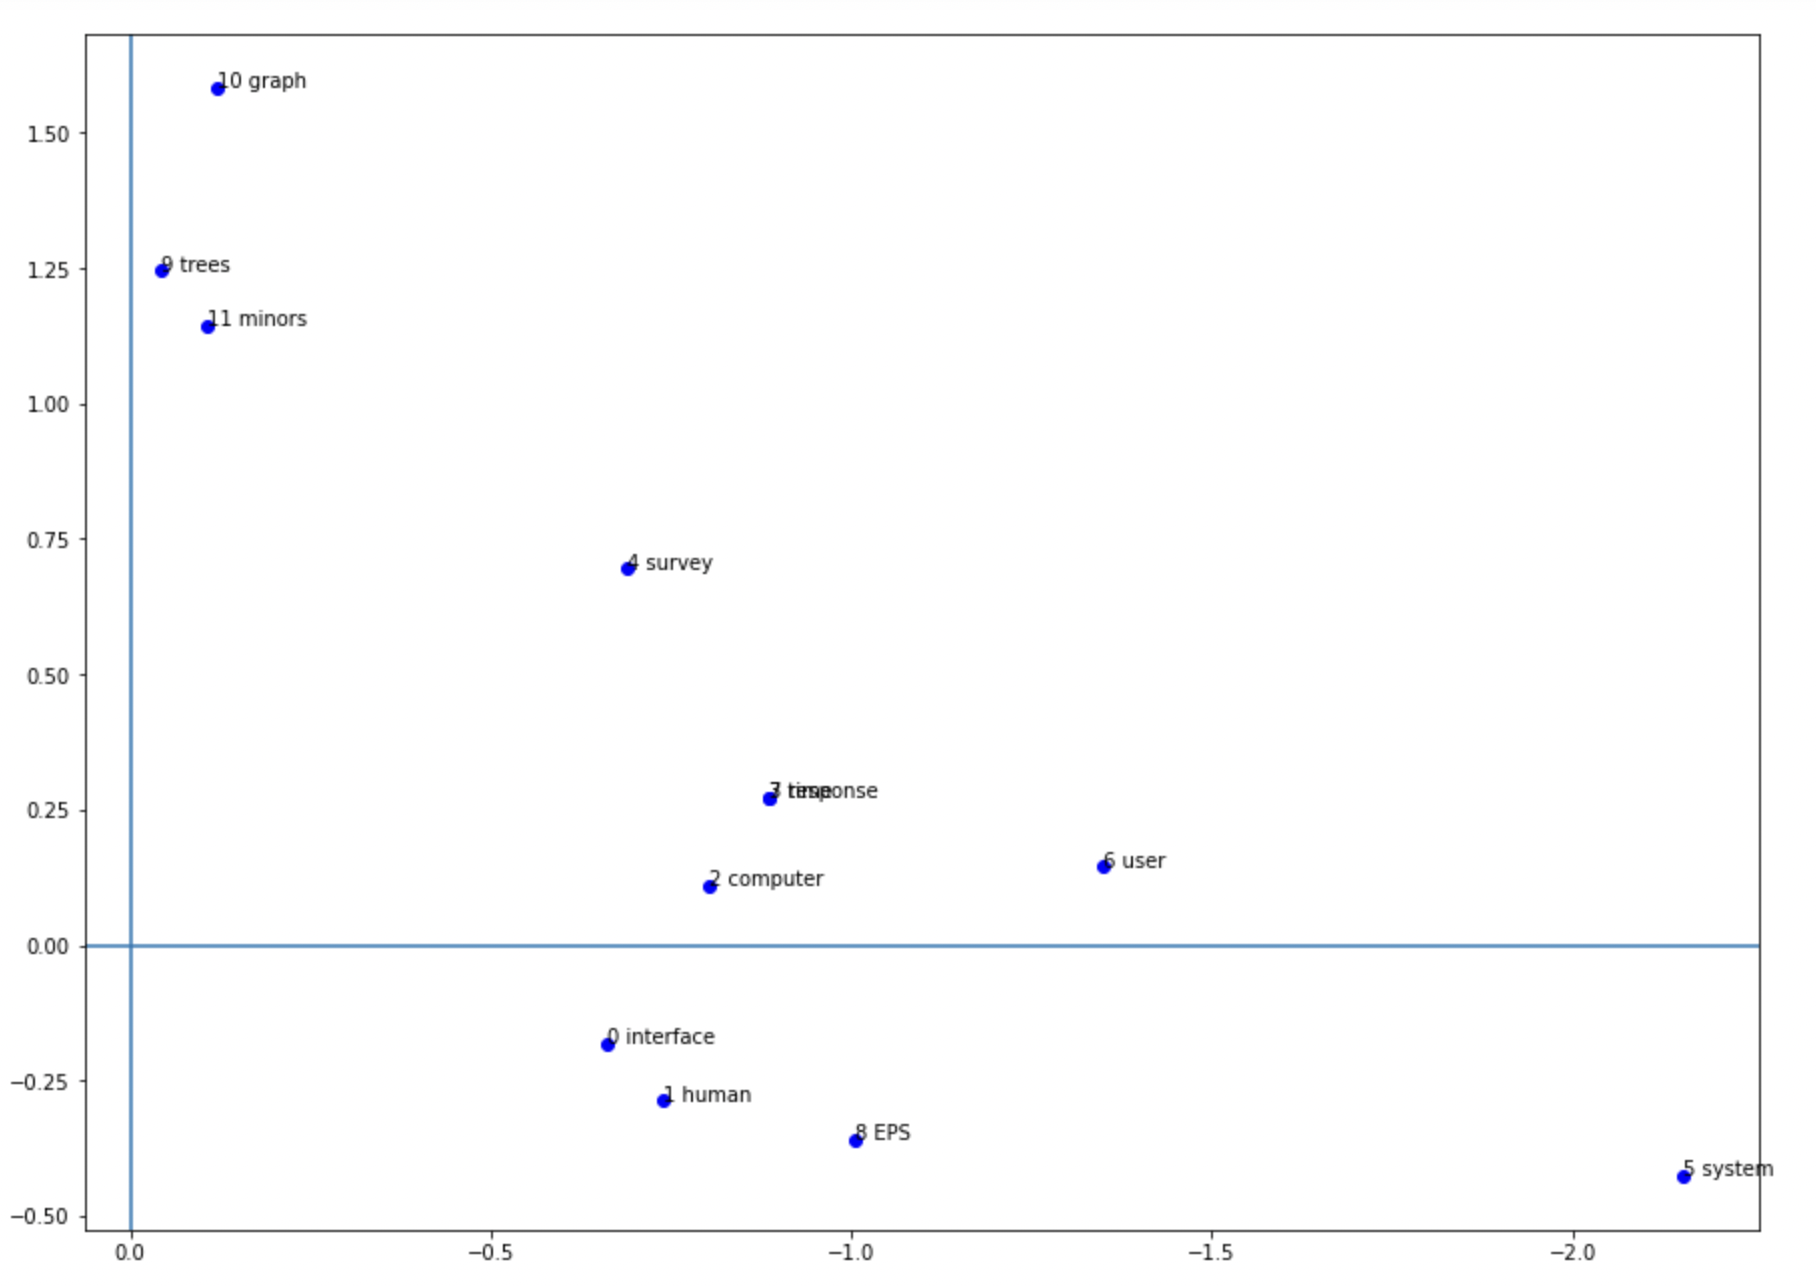

## <CENTER>Task-3 (10 Points)

### Find matching documents for given document

In [29]:
documents

['Human machine interface for Lab ABC computer applications',
 'A survey of user opinion of computer system response time',
 'The EPS user interface management system',
 'System and human system engineering testing of EPS',
 'Relation of user-perceived response time to error measurement',
 'The generation of random, binary, unordered trees',
 'The intersection graph of paths in trees',
 'Graph minors IV: Widths of trees and well-quasi-ordering',
 'Graph minors: A survey']

In [30]:
build_td_matrix(documents, word_to_ix).transpose().shape

(9, 12)

In [31]:
# Hint create query vector for input document. Calculate its cosine distance from other documents
from numpy.linalg import norm

def query(s, Uk, Sk, Vk_t, word_to_ix, documents, min_score=0.9):
    '''
    Input:
        s:query document.
        Uk:Term matrix
        Sk:singular value matrix
        Vk_t:Document matrix
        word_to_ix: {word, index} map
        documents:list of document
        min_score:min score beyond which documents are considerd matching
    Output:
        q_hat: coordinates of query vector
        matches: list of tuples containing matching document and its score
    '''
    
    s_t = build_td_matrix([s], word_to_ix).transpose()
    q_hat = np.dot(s_t,Uk)
    
    A = build_td_matrix(documents, word_to_ix)
    matches = []
    
    for i in range(len(documents)):
        document_array = np.dot(A[:,i].transpose(),Uk)
        
        a = q_hat
        b = document_array 
        cos_sim = float(np.dot(a, b)/(norm(a)*norm(b)))
        
        if cos_sim >= min_score:
            matches.append((documents[i],cos_sim))
            
    q_hat = q_hat.flatten()
    
    return q_hat, matches

In [32]:
q_hat, matches = query('human computer interaction', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)
print(q_hat)
if matches is not None:
    print(matches)
else:
    print("No matches found")

[-0.461821   -0.07002767]
[('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('A survey of user opinion of computer system response time', 0.937486366968657), ('The EPS user interface management system', 0.9984452813340272), ('System and human system engineering testing of EPS', 0.986588640555659), ('Relation of user-perceived response time to error measurement', 0.9075594362644294)]


##### Expected
```CPP
[-0.461821   -0.07002767]
[('The EPS user interface management system', 0.9984452813340272), ('Human machine interface for Lab ABC computer applications', 0.9980930095689974), ('System and human system engineering testing of EPS', 0.9865886405556598), ('A survey of user opinion of computer system response time', 0.9374863669686595), ('Relation of user-perceived response time to error measurement', 0.9075594362644345)]
```

### Visual representation of query/document

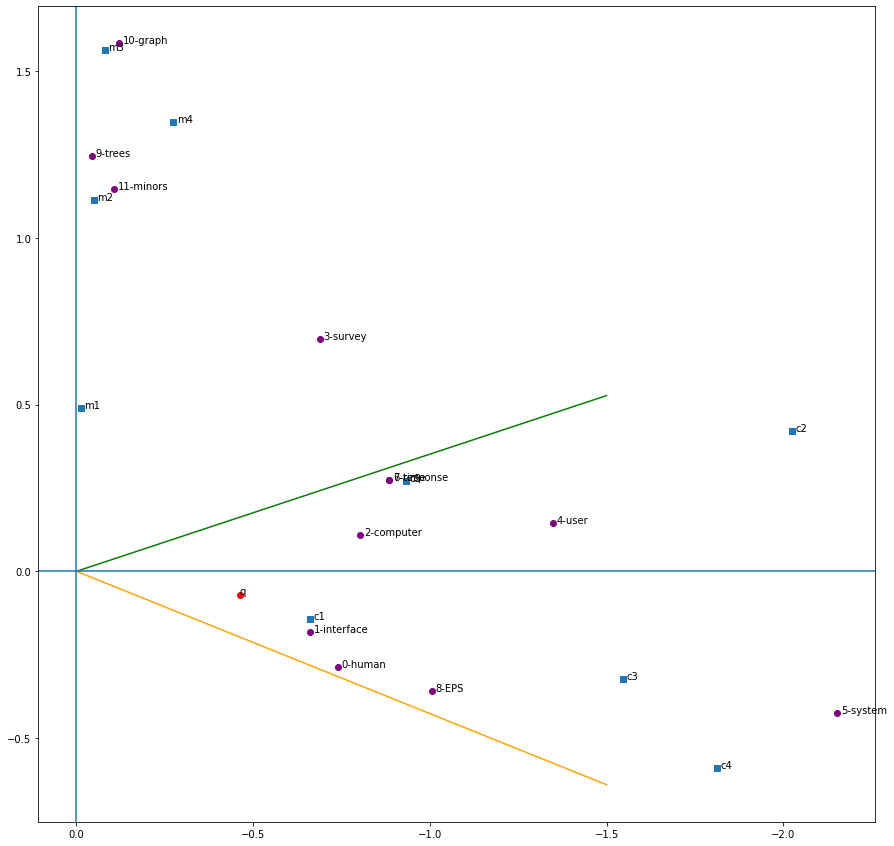

In [33]:
# Plot terms, documents and query documents along with lines representing its cosine angle 
import math

import numpy as np
from matplotlib import pyplot as plt

# Set figure size
plt.figure(figsize=(15,15))

# Scatter plot
x1 = documents_array[:,0]
y1 = documents_array[:,1]
plt.scatter(x1, y1, marker='s')

# Annotate
for i, j in enumerate(docName):
    plt.annotate(j, (x1[i]-0.01, y1[i]))

# Scatter plot
x2 = terms_array[:,0]
y2 = terms_array[:,1]
plt.scatter(x2, y2, color='purple')

# Annotate
for i, j in enumerate(word_to_ix):
    plt.annotate(str(i)+ "-" + j, (x2[i]-0.01, y2[i]))
    
# Query
plt.scatter(q_hat[0], q_hat[1], color='red')
plt.annotate("q", (q_hat[0], q_hat[1]))

# Cosine lines
line_0_x = np.linspace(-1.5,0,10)
line_0_y = -np.cos(q_hat[0] -0.75)*(line_0_x) 
plt.plot(line_0_x,line_0_y,c='green')

line_2_x = np.linspace(-1.5,0,10)
line_2_y = np.cos(q_hat[1] +1.20) * (line_2_x)
plt.plot(line_2_x,line_2_y,c='orange')
    
# Invert the axis
plt.gca().invert_xaxis()

# Axis lines
plt.axhline(0)
plt.axvline(0)

# Display the plot
plt.show()

##### Expected

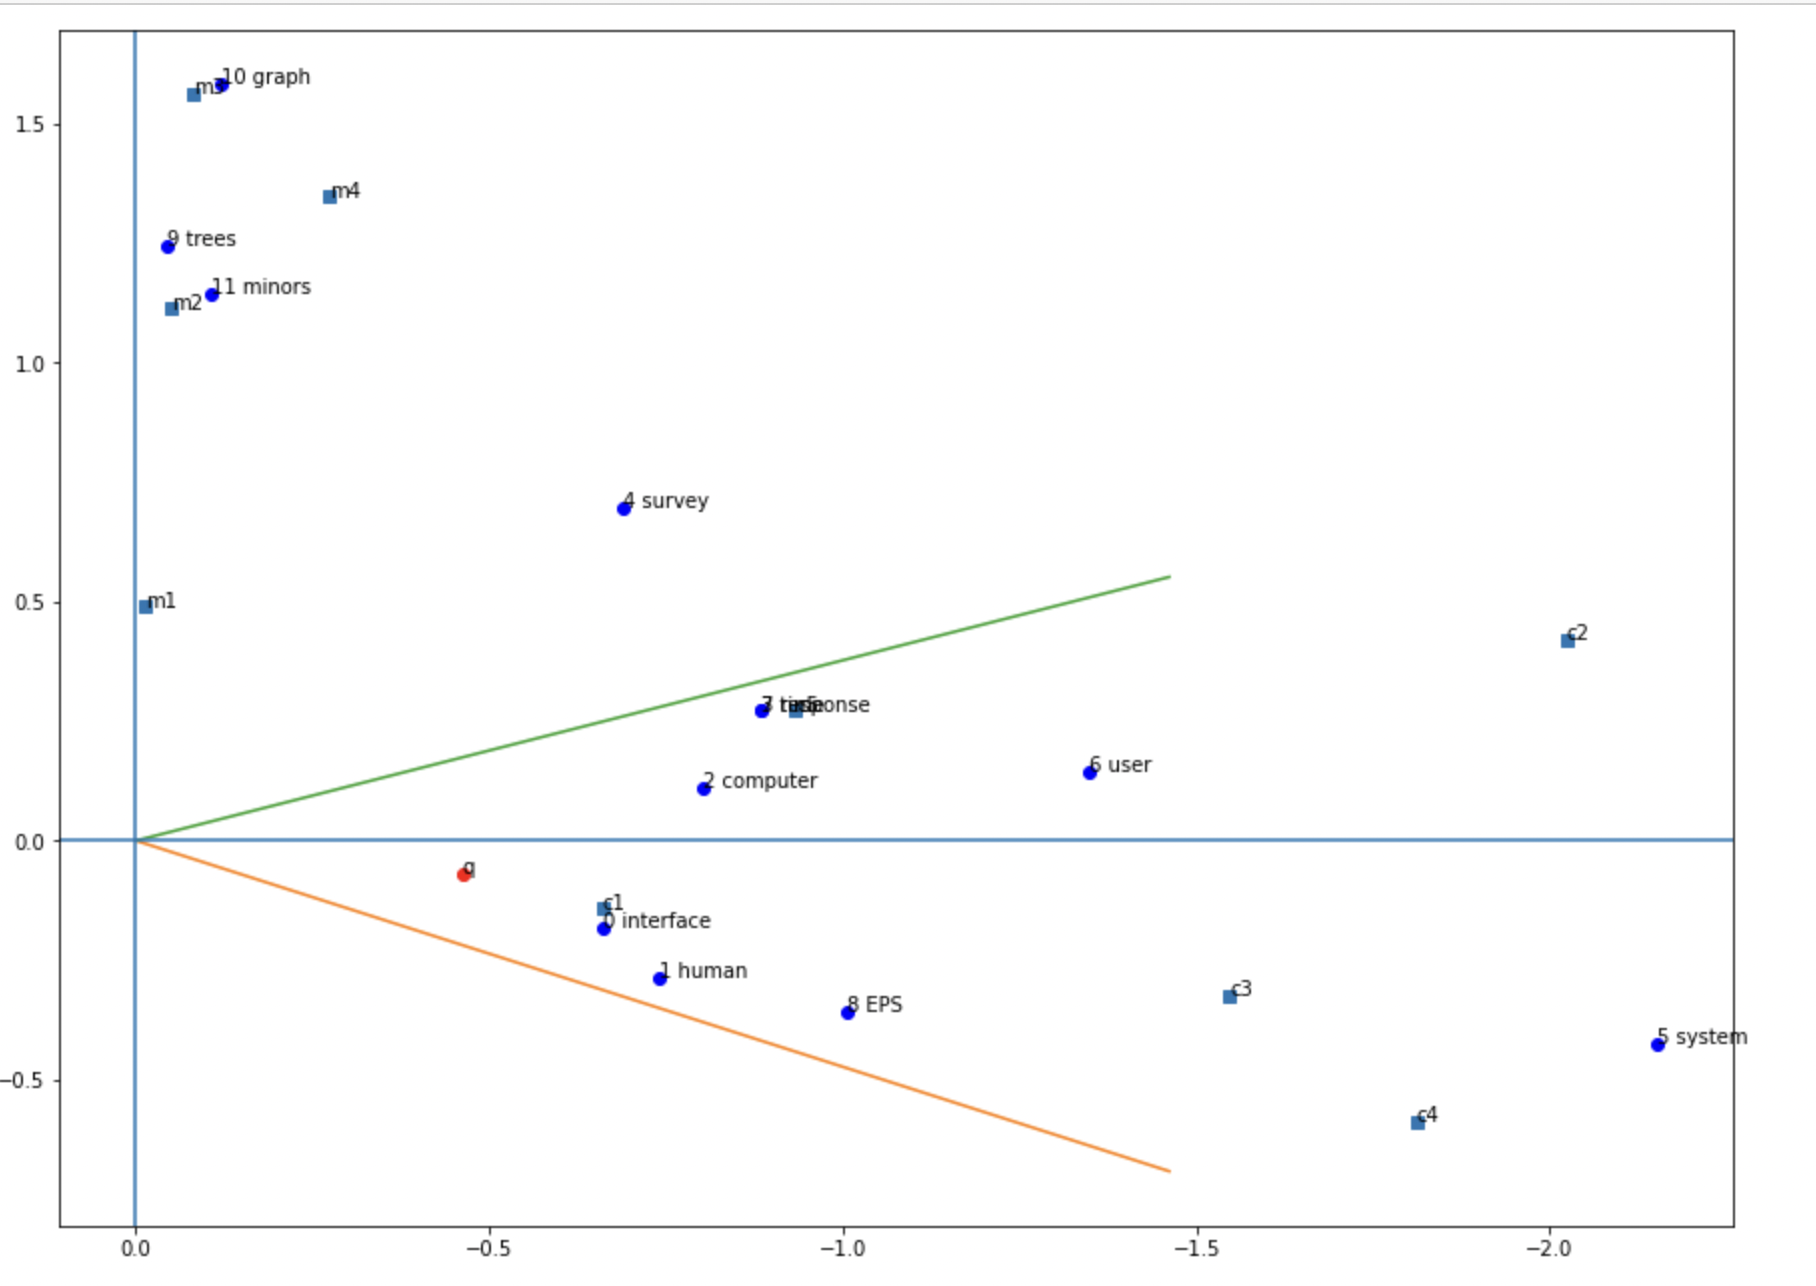


## **Theory questions: (5 points)**
- A) Give short description of Left-eigen vectors, right-eigen vectors and eigen-values matrix retured by Singular Value Decompostion of document-terms count matrix.
- B) Visually represent the document "Graph and tree generation" in 2D space along with words and documents as given in previous question.

Singular value decomposition (SVD) is a method of representing a matrix as a series of linear approximations that expose the underlying meaning-structure of the matrix. The singular value decomposition of a matrix A is the factorization of A into the
product of three matrices A = UDV'

The columns of U are called the left singular vectors, and those of V are called the right singular vectors.

A nonzero vector X such that TX = λX is called an eigen-vector and the scalar λ is called an eigenvalue of the linear operator T.
D is the diagonal matrix that describes the eigenvalue of each eigenvector.

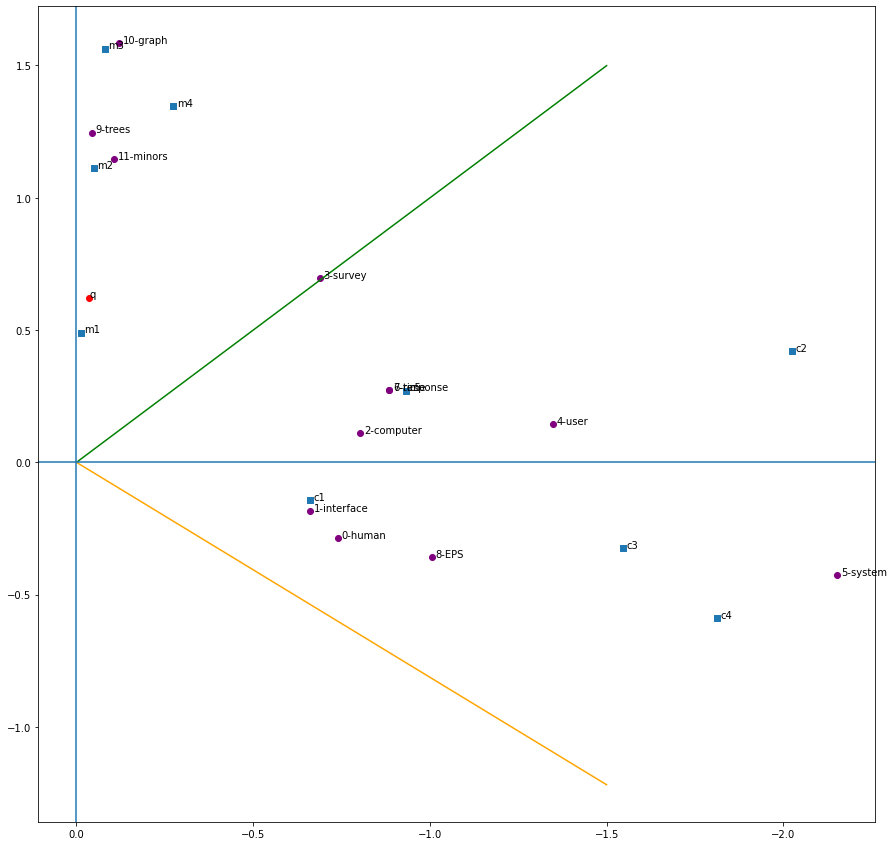

In [34]:
# PART B

q_hat, matches = query('Graph and tree generation', Uk, Sk, Vk_t, word_to_ix, documents, 0.9)

# Set figure size
plt.figure(figsize=(15,15))

# Scatter plot
x1 = documents_array[:,0]
y1 = documents_array[:,1]
plt.scatter(x1, y1, marker='s')

# Annotate
for i, j in enumerate(docName):
    plt.annotate(j, (x1[i]-0.01, y1[i]))

# Scatter plot
x2 = terms_array[:,0]
y2 = terms_array[:,1]
plt.scatter(x2, y2, color='purple')

# Annotate
for i, j in enumerate(word_to_ix):
    plt.annotate(str(i)+ "-" + j, (x2[i]-0.01, y2[i]))
    
# Query
plt.scatter(q_hat[0], q_hat[1], color='red')
plt.annotate("q", (q_hat[0], q_hat[1]))

# Cosine lines
line_1_x = np.linspace(-1.5,0,2)
line_1_y = -np.cos(q_hat[0])*(line_1_x) + 0
plt.plot(line_1_x,line_1_y,c='green')

line_2_x = np.linspace(-1.5,0,2)
line_2_y = np.cos(q_hat[1])*(line_2_x) + 0
plt.plot(line_2_x,line_2_y,c='orange')
    
# Invert the axis
plt.gca().invert_xaxis()

# Axis lines
plt.axhline(0)
plt.axvline(0)

# Display the plot
plt.show()

# Q2. n-Gram Language Models

Your task is to train n-gram language models. [Ref SLP Chapter 3]

- Task 1: You will train unigram, bigram, and trigram models on given training files. Then you will score on given test files for unigram, bigram, and trigram. you will generate sentences from the trained model and compute perplexity.
- Task 2: You will create training data for n > 3. and Repeat the above task from training model.
<h6>Part-A = (55 Points) </h6>

In [40]:
'''
Your imports go here
You are encouraged to implement your own functions and not use from library.
'''
import sys
from collections import Counter
import numpy as np
import pandas as pd
import math 
import random
import operator
import itertools
from collections import OrderedDict
import re
import nltk
from nltk.corpus import stopwords
nltk.download('stopwords')
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [41]:
# constants to define pseudo-word tokens
# access via UNK, for instance
# for this assignemnt we will follow <s> tag for beginning of sentence and
# </s> for end of senetence as suggested in SLP Book. Check sample training files for reference.
UNK = "<UNK>"
SENT_BEGIN = "<s>"
SENT_END = "</s>"

We need to initialise global variables for model

In [42]:

"""Initializes Parameters:
  n_gram (int): the n-gram order.
  is_laplace_smoothing (bool): whether or not to use Laplace smoothing
  threshold: words with frequency  below threshold will be converted to token
"""
# Initializing different object attributes
n_gram = 2
is_laplace_smoothing = True
vocab = [] 
n_gram_counts = {}
n_minus_1_gram_counts = {}
threshold = 1


### Implement training function (10 points)

In [43]:
def make_ngrams(tokens: list, n: int) -> list:
    """Creates n-grams for the given token sequence.
    Args:
    tokens (list): a list of tokens as strings
    n (int): the length of n-grams to create

    Returns:
    list: list of tuples of strings, each tuple being one of the individual n-grams
    """
    ## Your code here
    n_grams = []
    length = 0
    while length < len(tokens)-(n-1):
        tmp_tup = (tokens[length],)
        for i in range(0,n-1):
            tmp_tup = tmp_tup + (tokens[length + i + 1],)
        n_grams.append(tmp_tup)
        length += 1
    return n_grams      

In [44]:
def train(training_file_path):
    """Trains the language model on the given data. Input file that
    has tokens that are white-space separated, has one sentence per line, and
    that the sentences begin with <s> and end with </s>
    Parameters:
      training_file_path (str): the location of the training data to read

    Returns:
    N Gram Counts, Vocab, N Minus 1 Gram Counts
    """
    vocab = []
    
    with open(training_file_path, 'r') as fh:
        content = fh.read().split() # Read and split data to get list of words
    
    # Get the count of each word
    count = {}
    for w in content:
        if w in count.keys():
            count[w] +=1
        else:
            count[w] = 1
            vocab.append(w)
    
    # Replace the words with <UNK> if count is < threshold(=1)
    for i in range(len(count)):
        if count[vocab[i]] <= threshold:
            vocab[i] = UNK
            
    # make use of make_n_grams function
    c_ngrams = make_ngrams(content, n_gram)
    n_gram_counts = Counter(c_ngrams)
    
    c_n_1grams = make_ngrams(content, n_gram - 1)
    n_minus_1_gram_counts = Counter(c_n_1grams)

    # For n>1 grams compute n-1 gram counts to compute probability
    return n_gram_counts, vocab, n_minus_1_gram_counts
    n_minus_1_grams = []
    n_minus_1_gram_counts = {}
    # For n>1 grams compute n-1 gram counts to compute probability
    if n_gram > 1:
        n_minus_1_grams = make_ngrams(content,n_gram-1)
        n_minus_1_gram_counts = Counter(n_minus_1_grams) 
    return n_gram_counts, vocab, n_minus_1_gram_counts

Output your Trained Data Parameters:

In [45]:
if n_gram == 1:
    n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training_uni.txt")
elif n_gram == 2:
    n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training_bi.txt")
else:
    n_gram_counts, vocab, n_minus_1_gram_counts = train("berp-training-tri.txt")
print(n_gram_counts)
print(vocab)

Counter({('</s>', '<s>'): 6755, ('<s>', 'i'): 1653, ('like', 'to'): 953, ('i', 'want'): 743, ('food', '</s>'): 670, ('to', 'eat'): 610, ('i', 'would'): 607, ('would', 'like'): 585, ('want', 'to'): 546, ("i'd", 'like'): 495, ('dollars', '</s>'): 457, ('<s>', "i'd"): 434, ('start', 'over'): 403, ('tell', 'me'): 390, ('over', '</s>'): 367, ('to', 'go'): 294, ('restaurant', '</s>'): 286, ('<s>', 'tell'): 282, ('to', 'have'): 280, ('me', 'about'): 252, ('<s>', 'start'): 237, ('dinner', '</s>'): 224, ('<s>', "let's"): 196, ('do', 'you'): 193, ('to', 'spend'): 187, ('<s>', 'uh'): 184, ('<s>', "i'm"): 178, ('show', 'me'): 178, ('lunch', '</s>'): 175, ('<s>', 'what'): 172, ("let's", 'start'): 170, ('i', "don't"): 167, ('<s>', 'do'): 166, ('<s>', 'can'): 160, ('more', 'than'): 151, ('give', 'me'): 151, ('<s>', 'the'): 147, ('restaurants', '</s>'): 146, ('information', 'about'): 145, ('can', 'you'): 143, ('less', 'than'): 136, ('can', 'i'): 135, ('me', 'more'): 131, ('<s>', 'how'): 131, ('<s>', '

### Scoring function (points 5):
Implement Score function that will take input sentence and output probability of given string representing a single sentence.

In [47]:
def score(sentence):
    """Calculates the probability score for a given string representing a single sentence.
    Parameters:
      sentence (str): a sentence with tokens separated by whitespace to calculate the score of
      
    Returns:
      float: the probability value of the given string for this model
    """
    n = n_gram
    
    # Split the input sentence and replace out of vocabulary tokens with <UNK> 
    #if type(sentence) is str:
    sentence = sentence.split()
    sentence = [UNK if item not in vocab else item for item in sentence]
    
    ngram = make_ngrams(sentence,n)
    
    # Calculate probability for each word and multiply(or take log and sum) them to get the sentence probability
    probability = 1
    for t in ngram:
        if t in n_gram_counts and t[:-1] in n_minus_1_gram_counts:
            num = n_gram_counts[t]
        else:
            num = 1
            
        if t[:-1] in n_minus_1_gram_counts:
            den = n_minus_1_gram_counts[t[:-1]]
            
        else:
            den = 1
        p = float((num + 1)/(den + len(vocab)))
        #print(prob)
        
        probability *= p

    
    return probability

In [51]:
with open("hw2-test_bi.txt", 'r') as fh:
    test_content = fh.read().split("\n")
num_sentences_1 = len(test_content)
ten_sentences_1 = test_content[:10]
print("# of test sentences: ", num_sentences_1)
probablities = []

# of test sentences:  100


In [52]:
# print probabilities/score of sentences in test content
for sentence in test_content:
  probablities.append(score(sentence))
probablities = np.array(probablities)
mean = np.mean(probablities)
std_dev = np.std(probablities)

In [53]:
print(mean)

2.486061645372695e-05


In [54]:
print(std_dev)

0.00015577562123348062


In [55]:
print(probablities)

[1.44987340e-09 3.89169715e-08 9.36482476e-17 1.17790171e-14
 5.81642648e-20 1.23850254e-13 6.74573238e-13 9.92138568e-26
 4.03836826e-17 3.50061733e-07 2.23919517e-09 5.71156739e-11
 9.72698286e-15 1.00165960e-05 5.59714113e-12 5.13825653e-06
 1.78281605e-05 2.87186105e-06 1.93523493e-13 6.48126388e-21
 6.17601502e-34 2.38610085e-35 6.75108648e-20 2.99805803e-18
 7.52767664e-17 1.93749689e-10 3.50983451e-06 5.57878220e-10
 1.75666078e-21 1.19689131e-12 1.00948958e-09 4.23080966e-16
 1.97745775e-14 1.29244224e-11 4.24919098e-18 2.01869289e-16
 2.47045390e-08 1.21573912e-08 3.00038286e-14 1.35696248e-10
 7.46364051e-14 1.05571355e-12 4.87759715e-12 2.50393411e-17
 2.83075605e-16 2.98789532e-16 7.63990788e-11 2.05269002e-10
 1.13923135e-17 3.50974619e-20 8.18561249e-23 5.07981697e-15
 3.28874548e-06 1.12576622e-04 1.12576622e-04 3.96735591e-13
 9.76999313e-13 1.90763839e-06 1.11781005e-08 1.16380360e-14
 1.30120623e-03 3.53275295e-15 6.11224801e-16 2.45466324e-12
 5.36540454e-23 8.144196

### Sentence generation (10 points)
Generate sentence from the above trained model
- To generate next word from a set of probable n-grams and their probabilities check below tutorial:
https://numpy.org/doc/stable/reference/random/generated/numpy.random.choice.html

In [56]:
def generate_sentence():
    """Generates a single sentence from a trained language model using the Shannon technique.
      
    Returns:
      str: the generated sentence
    """
    prev_word = SENT_BEGIN
    update = []
    
    n = 2
    # Start with <s> and randomly generate words until we encounter sentence end
    # Append sentence begin markers for n>2
    # Keep track of previous word for stop condition
    if n > 1:
        while prev_word != "</s>":
        # Construct the (n-1) gram so far
        # Get the counts of all available choices based on n-1 gram
        # Convert the counts into probability for random.choice() function
        # If <s> is generated, ignore and generate another word
            temp = {}
            for key,val in n_gram_counts.items():
                if key[-2] == prev_word:
                    p = 0
                    if key[:-1] in n_minus_1_gram_counts:
                        p = float(val/n_minus_1_gram_counts[key[:-1]])
                    temp[key] = p
            if temp:
                w_t = list(temp.keys())
                v = list(temp.values())
                rand = np.random.choice(range(len(w_t)),1,p = v)
                prev_word = w_t[rand[0]][-1]
                update.append(prev_word)

    # else:
   
   # In case of unigram model, n-1 gram is just the previous word and possible choice is whole vocabulary
    #   while prev_word != "</s>":
    #     # Convert the counts into probability for random.choice() function
    #     # If <s> is generated, ignore and generate another word
    
    
    # # Append sentence end markers for n>2

    update.insert(0, SENT_BEGIN)
    sentence = ' '.join(update)
    
    return sentence

In [57]:
def generate(n):
    """Generates n sentences from a trained language model using the Shannon technique.
    Parameters:
      n (int): the number of sentences to generate
      
    Returns:
      list: a list containing strings, one per generated sentence
    """
    # Generate sentences one by one and store
    sentences = []

    # Generate sentences one by one and store
    for i in range(n):
        sentences.append(generate_sentence())

    return sentences

In [58]:
sentences = generate(50)
print("Sentences:")
for sentence in sentences:
  print(sentence)

Sentences:
<s> i feel like a malaysian food on bucci's </s>
<s> not more information about khasba </s>
<s> okay uh i don't want to a cheap french restaurant </s>
<s> i need reservations for szechuan food </s>
<s> cost five or saturdays </s>
<s> and grill </s>
<s> i would like to pay ten minutes away </s>
<s> thai house </s>
<s> tell me some french food restaurant </s>
<s> i'd like to have lunch </s>
<s> it costs about panini </s>
<s> i would spend less than ten to have any kind of food at that allows smoking </s>
<s> why don't want to have other seafood restaurants with burritos and the list of food today for this restaurant where could be more about fifteen minutes </s>
<s> i want to eat on the area </s>
<s> tell me about la tour eiffel </s>
<s> i want to have any distance should cost eight dollars </s>
<s> i'd like to spend less than one looks interesting </s>
<s> tell me the weekend </s>
<s> metropole </s>
<s> howbout the costs </s>
<s> i'm willing to eat on saturday for a weekday <

### Evaluate model perplexity (5 points)
Measures the perplexity for the test sequence with your trained model. 
you may assume that this sequence may consist of many sentences "glued together"

The perplexity of the given sequence is the inverse probability of the test set, normalized by the number of words.


In [59]:
# Since this sequence will cross many sentence boundaries, we need to include 
# the begin- and end-sentence markers <s> and </s> in the probability computation. 
# We also need to include the end-of-sentence marker </s> 
# but not the beginning-of-sentence marker <s>) in the total count of word tokens N

def perplexity(test_sequence):
    """.
    Parameters:
      test_sequence (string): a sequence of space-separated tokens to measure the perplexity of

    Returns:
      float: the perplexity of the given sequence
    """ 

    # Replace out of vocab words with <UNK>, already done in score function
    # test_sequence = [token if token in vocab else UNK for token in test_sequence.split()]


    # Remove sentence begin markers from data for computing N
    # Get the probability for the sequence
    N = 0
    split = test_sequence.split()
    for w in split:
        if w != SENT_BEGIN:
            N +=1

    # Get the probability for the sequence
    #num = len(test_sequence)
    p = score(test_sequence)
    perplexity = p ** (-1/N)
    
    return perplexity

In [60]:
print(perplexity(" ".join(sentences[0:10])))

70.86065084221755


### **Explore and explain: (5 points)**
* Experiment n_gram model for n = [1,2,3..7] of your choice. Explain the best choice of n that generates more meaninful sentences.


The n_gram model was experimented for differnt values of n for n-grams. It was observed that for trigrams, that is n=3, the prediction is better. There is a need to select the optimal vlaue of n as increasing n woudl increase performance but also the time to compute the same. This may be due to the Trigrams containing the information of bigrams and able to predict the next word better resulting in more accuracy.

# Q3. Classification using LSTM - using Tensorflow (30 Points)
In this part, we will be building a bidirectional LSTM network to train and inference sentiment analysis on IMDB dataset.<br>

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time to tweak your hyperparameters.
- Without a GPU, You might have to wait longer to experiment.

### Library Imports

In [69]:
import tensorflow as tf
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow_datasets as tfds

from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer



### Visualizing data distribution (1 Point)


In [70]:
## Reading the data and removing columns that are not important. 
dataset = pd.read_csv("movie_reviews.csv", sep = ',', encoding = 'latin-1', usecols = lambda col: col not in ["Unnamed: 2", "Unnamed: 3", "Unnamed: 4"])

In [71]:
 #######################################################   
 # print head of data frame with help of head function # 
 #######################################################
 dataset.head()


review sentiment
0  One of the other reviewers has mentioned that ...  positive
1  A wonderful little production. <br /><br />The...  positive
2  I thought this was a wonderful way to spend ti...  positive
3  Petter Mattei's "Love in the Time of Money" is...  positive
4  Probably my all-time favorite movie, a story o...  positive

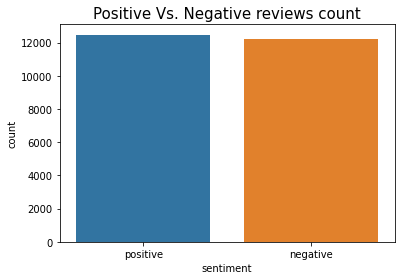

In [72]:
 ####################################################### 
 # plot Positive Vs. Negative reviews count            # 
 #######################################################

sns.countplot(x='sentiment',data=dataset)

plt.title("Positive Vs. Negative reviews count", fontsize = 15)
plt.show()



### Cleaning the Reviews (2 Points)

In [73]:
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize import word_tokenize
import string
import pandas as pd
import re
import nltk
nltk.download('omw-1.4')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('words')

stopword = nltk.corpus.stopwords.words('english')
wn = nltk.WordNetLemmatizer()
ps = nltk.PorterStemmer()
words = set(nltk.corpus.words.words())

# From the first assignment
def clean_text(text):
    text = text.lower()
    text = re.sub(r"http\S+", "", text)
    text = re.sub(r"www.\S+", "", text)
    text_links_removed = "".join([char for char in text if char not in string.punctuation])
    text_cleaned = " ".join([word for word in re.split('\W+', text_links_removed)
        if word not in stopword])
    text = " ".join([wn.lemmatize(word) for word in re.split('\W+', text_cleaned)])
    return text

[nltk_data] Downloading package omw-1.4 to /root/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package words to /root/nltk_data...
[nltk_data]   Package words is already up-to-date!


In [74]:
 #############################################################################################  
 # Clean all the reviews in the dataset using the clean_text function provided above         # 
 ############################################################################################# 
for idx in dataset.index:
    text = clean_text(dataset['review'][idx])
    dataset.at[idx, "review"] = text

In [75]:
 #####################################################################
 # print head of the "CLEANED" data frame with help of head function # 
 #####################################################################
 dataset.head()


review sentiment
0  one reviewer mentioned watching 1 oz episode y...  positive
1  wonderful little production br br filming tech...  positive
2  thought wonderful way spend time hot summer we...  positive
3  petter matteis love time money visually stunni...  positive
4  probably alltime favorite movie story selfless...  positive

### Splitting the dataset and Encoding Labels (2 Points)

Spliting data: <br> 
80% for the training and the remaining 20% for validation.

Encoding Labels: <br>
Encode labels as negative and positive as 0 and 1 respectively


In [76]:
#################################################################################
# Split the data using the sklearn module                                       #
# 80% for the training and the remaining 20% for validation                     #
#################################################################################
from sklearn.model_selection import train_test_split

x=dataset.review
y=dataset.sentiment
x_train1,x_test1,y_train1,y_test1=train_test_split(x,y,test_size=0.20,random_state=12)

In [77]:
#################################################################################
# Initialize label encoder from sklearn module                                  #
# fit on train labels and transform both train and validation labels            #
#################################################################################
from sklearn import preprocessing

le = preprocessing.LabelEncoder()

# fit on train labels and transform both train and validation labels
X_train_lenc = x_train1.tolist()
X_val_lenc = x_test1.tolist()

X_train_lenc = le.fit_transform(X_train_lenc)
X_val_lenc = le.fit_transform(X_val_lenc)

y_train_lenc = y_train1.tolist()
y_val_lenc = y_test1.tolist()

y_train_lenc = le.fit_transform(y_train_lenc)
y_val_lenc = le.fit_transform(y_val_lenc)

### Pre-Processing The Text (5 Points)
 

In [78]:
# You can use the modules given below
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer

###############################################################################  
# Fit your tokenizer on the training reviews                                  #
###############################################################################
t = Tokenizer()
t.fit_on_texts(x_train1)

#################################################################################################
# The word_index dictionary assigns a unique index to each unique word present in the training  #
# reviews.                                                                                      #
#                                                                                               #
# Create the word_index dictionary using the tokenizer                                          #
# Find the vocabulary of your training reviews                                                  #
#################################################################################################

word_index = {}

vocabulary = t.word_index


#################################################################################################
# Convert the reviews in the dataset to their index form by using a function available          #
# with the tokenizer                                                                            #
# HINT : convert training and validation reviews into sequences                                 #
#################################################################################################

encoded_train = t.texts_to_sequences(x_train1)
encoded_test = t.texts_to_sequences(x_test1)

#################################################################################################
# Pad the the training and validation sequences so all of them have the same length             # 
# set maxlen = 200                                                                              #
#################################################################################################

padded_train = pad_sequences(encoded_train, maxlen=200, padding='post')
padded_test = pad_sequences(encoded_test, maxlen=200, padding='post')

# maxlen which is the maximum length of one review we will use for our training

print('Vocabulary : {}'.format(vocabulary))

Vocabulary : {'br': 1, 'movie': 2, 'film': 3, 'one': 4, 'like': 5, 'time': 6, 'good': 7, 'character': 8, 'get': 9, 'even': 10, 'would': 11, 'story': 12, 'make': 13, 'see': 14, 'really': 15, 'scene': 16, 'well': 17, 'much': 18, 'people': 19, 'also': 20, 'great': 21, 'bad': 22, 'show': 23, 'dont': 24, 'first': 25, 'way': 26, 'thing': 27, 'made': 28, 'think': 29, 'could': 30, 'life': 31, 'go': 32, 'know': 33, 'watch': 34, 'many': 35, 'love': 36, 'seen': 37, 'two': 38, 'actor': 39, 'never': 40, 'plot': 41, 'say': 42, 'look': 43, 'acting': 44, 'little': 45, 'best': 46, 'end': 47, 'year': 48, 'ever': 49, 'take': 50, 'better': 51, 'still': 52, 'man': 53, 'come': 54, 'work': 55, 'find': 56, 'part': 57, 'something': 58, 'give': 59, 'want': 60, 'im': 61, 'lot': 62, 'director': 63, 'real': 64, 'back': 65, 'performance': 66, 'guy': 67, 'watching': 68, 'doesnt': 69, 'though': 70, 'play': 71, 'didnt': 72, 'woman': 73, 'actually': 74, 'nothing': 75, 'funny': 76, 'another': 77, 'new': 78, 'going': 79,

### Using glove vectors for embedding (5 Points)

GloVe vectors capture both global statistics and local statistics of a corpus. We use GloVe to convert words to embeddings in the vector space based on their semantics. 

We will be using the 200-dimensional GloVe vectors for the task at hand.

To learn more about GloVe please read the following resource:
- https://nlp.stanford.edu/pubs/glove.pdf

In [ ]:
glove_dictionary = {}
with open('glove.6B.200d.txt') as file:
    for each_line in file:
        words_in_line, coeff_cients = each_line.split(maxsplit=1)
        coeff_cients = np.array(coeff_cients.split(),dtype = float)
        glove_dictionary[words_in_line] = coeff_cients

In [ ]:
 # All the words which are not in the GloVe dictionary will be assigned a zero vector.

vocab_len=len(vocabulary)
embedding_matrix = np.zeros((vocab_len+1, 200))

######################################################################
# The glove_dictionary contains words vs their respective embeddings #
#                                                                    #
# Create the embedding matrix using the glove_dictionary             #
######################################################################
for word, i in vocabulary.items():
    embedding_vector = glove_dictionary.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector


In [ ]:
embedding_matrix.shape

(100048, 200)

In [ ]:
from tensorflow.keras.layers import Embedding, LSTM, Dense, Bidirectional, Input



Sample output : (99987, 200)

### Creating The Model (10)

If you need a refresher or have never worked with Neural Networks before, here are a few resources:
- https://web.stanford.edu/~jurafsky/slp3/7.pdf
- https://web.stanford.edu/~jurafsky/slp3/9.pdf
- https://colah.github.io/posts/2015-08-Understanding-LSTMs/


Training a neural network model will take time. 
- You can use Google Colab / Kaggle notebooks. You get a free GPU for a limited time.
- Without a GPU, You might have to wait longer to experiment.


Useful resources : <br>
https://www.tensorflow.org/api_docs/python/tf/keras/Sequential <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dense <br>
https://www.tensorflow.org/api_docs/python/tf/keras/layers/Dropout <br>





In [ ]:
import tensorflow as tf

tf.random.set_seed(42)

######################################################
# Complete this linear model in tensorflow           #
######################################################

def build_model(embedding_matrix):

  ''' 
  Arguments:
    embedding_matrix : a matrix with the corresponding embeddings
    of all words.

  Returns:
    The LSTM model that you created.
  '''
  
  model = tf.keras.Sequential()

  # TO DO: layer 1 : add embedding layer
  # The embedding layer maps the words to their embedding vectors from the embedding matrix
  model.add(tf.keras.layers.Embedding(input_dim=vocab_len +1,
                            output_dim=200,
                            weights=[embedding_matrix],
                            input_length=200,
                            trainable=False))

  # TO DO: layer 2 : add Bidirectional LSTM Layer 
  model.add(tf.keras.layers.Bidirectional(LSTM(150, return_sequences=True)))

  model.add(tf.keras.layers.Dropout(0.5))

  # TO DO Add more layers : you can add more dense layers and dropout
  # NOTE : You should be able to achieve an validation accuracy greater than 85%
  #        within 10 epochs
  model.add(tf.keras.layers.Bidirectional(LSTM(150, return_sequences=True)))

  model.add(tf.keras.layers.Dropout(0.5))

  model.add(tf.keras.layers.Bidirectional(LSTM(150)))

  model.add(tf.keras.layers.Dense(128, activation='relu'))

  model.add(tf.keras.layers.Dropout(0.5))


  # TO DO Final layer : add output layer and activation 
  model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

  # model = Model(input=l2, output=l6)
  # TO DO : use a loss function, optimizer as adam to compile 
  # and evaluate model on auc,precision,recall,accuracy
  # HINT : choose your loss function based on the task (binary classification)
  adam = tf.keras.optimizers.Adam(learning_rate = 0.0001)
  model.compile(loss = 'binary_crossentropy' , optimizer = adam, metrics = ['accuracy','AUC','Precision','Recall'])
  return model

In [ ]:
# NOTE : You should be able to achieve an validation accuracy greater than 85%
#        within 10 epochs

#################################################################
# Call the build_model function and initialize the model        #
#################################################################
model1 = build_model(embedding_matrix)
model1.summary()
#######################################################################################################
# train and validate the model on the padded sequences of text which we have created initially        #
#######################################################################################################
history1 = model1.fit(padded_train, y_train_lenc, validation_data=(padded_test,y_val_lenc), epochs=10,batch_size = 100)

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_2 (Embedding)     (None, 200, 200)          20009600  
                                                                 
 bidirectional_2 (Bidirectio  (None, 200, 300)         421200    
 nal)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 200, 300)          0         
                                                                 
 bidirectional_3 (Bidirectio  (None, 200, 300)         541200    
 nal)                                                            
                                                                 
 dropout_2 (Dropout)         (None, 200, 300)          0         
                                                                 
 bidirectional_4 (Bidirectio  (None, 300)             

### Plotting Accuracy and Losses (5 Points)
 




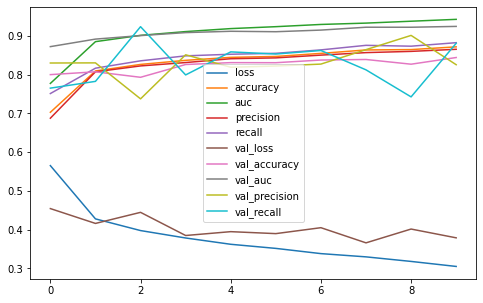

In [ ]:
####################################
# PLOT :                           #
# train loss vs val loss           #
# train auc vs val auc             #
# train recall vs val recall       #
# train precision vs val precision #
# train accuracy vs val accuracy   #
####################################
pd.DataFrame(history1.history).plot(figsize=(8,5))


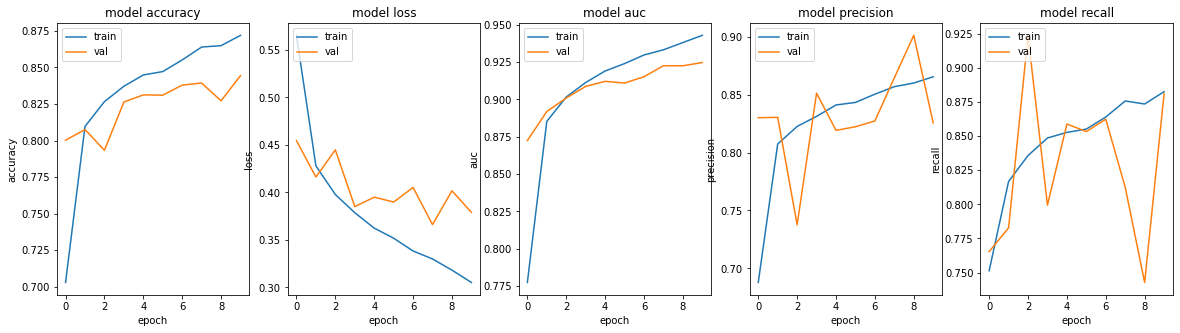

In [ ]:
from matplotlib import pyplot as plt

plt.rcParams["figure.figsize"] = (20,5)

#accuracy
subplot1 =plt.subplot(1,5,1)
subplot1.plot(history1.history['accuracy'])
subplot1.plot(history1.history['val_accuracy'])
subplot1.set_title('model accuracy')
subplot1.set_ylabel('accuracy')
subplot1.set_xlabel('epoch')
subplot1.legend(['train', 'val'], loc='upper left')

#loss
subplot2 =plt.subplot(1,5,2)
subplot2.plot(history1.history['loss'])
subplot2.plot(history1.history['val_loss'])
subplot2.set_title('model loss')
subplot2.set_ylabel('loss')
subplot2.set_xlabel('epoch')
subplot2.legend(['train', 'val'], loc='upper left')

#AUC
subplot3 =plt.subplot(1,5,3)
subplot3.plot(history1.history['auc'])
subplot3.plot(history1.history['val_auc'])
subplot3.set_title('model auc')
subplot3.set_ylabel('auc')
subplot3.set_xlabel('epoch')
subplot3.legend(['train', 'val'], loc='upper left')

#precision
subplot4 =plt.subplot(1,5,4)
subplot4.plot(history1.history['precision'])
subplot4.plot(history1.history['val_precision'])
subplot4.set_title('model precision')
subplot4.set_ylabel('precision')
subplot4.set_xlabel('epoch')
subplot4.legend(['train', 'val'], loc='upper left')

#recall
subplot4 =plt.subplot(1,5,5)
subplot4.plot(history1.history['recall'])
subplot4.plot(history1.history['val_recall'])
subplot4.set_title('model recall')
subplot4.set_ylabel('recall')
subplot4.set_xlabel('epoch')
subplot4.legend(['train', 'val'], loc='upper left')

In [ ]:
# You will need to include the pickled model along with the other submission files
# The saved model will be used to verify your lstm's predictions on hidden reviews

##################################################################################
# Save your trained model as a pickle file named "lstm_classifier"               #
# You will be using this saved model to make predictions in the next module      #
##################################################################################

import pickle

pickle.dump(model1, open('lstm_classifier.pkl','wb'))

INFO:tensorflow:Assets written to: ram://164999e3-22f7-4550-b170-eba36fa4d6fe/assets


INFO:tensorflow:Assets written to: ram://164999e3-22f7-4550-b170-eba36fa4d6fe/assets


### Prediction (5 Points)

In [63]:
######################################################################
# Load your saved model                                              #
# Use the saved model to make predictions                            #
######################################################################
import pickle
saved_model = pickle.load(open('lstm_classifier.pkl', 'rb'))

In [64]:
# use the saved model to predict the reviews
def predict_review(review):
  '''
  Arguments:
    review : A single review for which you want to predict the sentiment for.
             example: "This movie was amazing! I would defenitely watch it again."

  Returns:
    The predicted sentiment for the review : either 1 or 0
  '''

 ############################################################################# 
 # Predict the sentiment for the given review using the model                #
 # that you trained and return the sentiment                                 #
 #                                                                           #
 # HINT : Remember that the review needs to be "preprocessed" before you use #
 # it for prediction                                                         #
 #############################################################################
  review = clean_text(review)
  review_enc = t.texts_to_sequences([review])
  review_pad = pad_sequences(review_enc, maxlen=200, padding='post')
  pred = saved_model.predict([review_pad])
  return 0 if pred<=0.5 else 1

In [79]:
# Do not edit this cell

for review in ["If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!!",
                "What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off.",
                "I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the tops. Brilliant Film.",
                "Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be."]:
    p = predict_review(review)
    print(f'{review[:200]} -> {p:.2f}')
    

If you like original gut wrenching laughter you will like this movie. If you are young or old then you will love this movie, hell even my mom liked it.<br /><br />Great Camp!!! -> 1.00
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative direction, too. Some VERY faint echoes of Fargo here, but it just doesn't come off. -> 0.00
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the romance between Joe and Jean keeps me on the edge of my seat, plus I still think Bryan Brown is the -> 1.00
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement value. About as unentertaining, uninstructive and just plain dull as a film can be. -> 0.00


### Expected Output:

If you like original gut wrenching laughter you will like this movie. If you are young or old then y -> 1 <br>
What a waste of talent. A very poor, semi-coherent, script cripples this film. Rather unimaginative  -> 0 <br>
I have seen this film at least 100 times and I am still excited by it, the acting is perfect and the -> 1 <br>
Cheap, amateurish, unimaginative, exploitative... but don't think it'll have redeeming amusement val -> 0